# =============================================================
# MILESTONE 3: Machine Learning Model Development and Optimization
# =============================================================

In [21]:
# 1. Train All Models
# python ../src/modeling/train_model.py

In [22]:
#  2. Evaluate All Models
# python ../src/modeling/evaluate.py

In [23]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pathlib import Path
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve
from IPython.display import display, HTML

In [25]:
# Paths
MODEL_DIR = Path("../models/trained_models")
STATIC_VIZ = Path("../visualizations/static")
INTER_VIZ = Path("../visualizations/interactive")
STATIC_VIZ.mkdir(parents=True, exist_ok=True)
INTER_VIZ.mkdir(parents=True, exist_ok=True)

# Load results
with open(MODEL_DIR / "evaluation_results.json") as f:
    data = json.load(f)

results = data["all_results"]
best_model = data["best_model"]

# Convert to DataFrame
metrics_df = pd.DataFrame([
    {k: v for k, v in r.items() if k not in ["y_true", "y_pred", "y_prob"]}
    for r in results
])
metrics_df = metrics_df.round(4)
print("MODEL COMPARISON")
display(metrics_df)

print(f"\nBEST MODEL: {best_model}")

MODEL COMPARISON


,model,accuracy,precision,recall,f1,roc_auc
0,Logistic Regression,0.8741,0.6585,0.2784,0.3913,0.8237
1,Decision Tree,0.8981,0.6330,0.7113,0.6699,0.8206
2,Random Forest,0.9460,0.9296,0.6804,0.7857,0.9262
3,Xgboost,0.9520,0.9114,0.7423,0.8182,0.9197



BEST MODEL: Xgboost


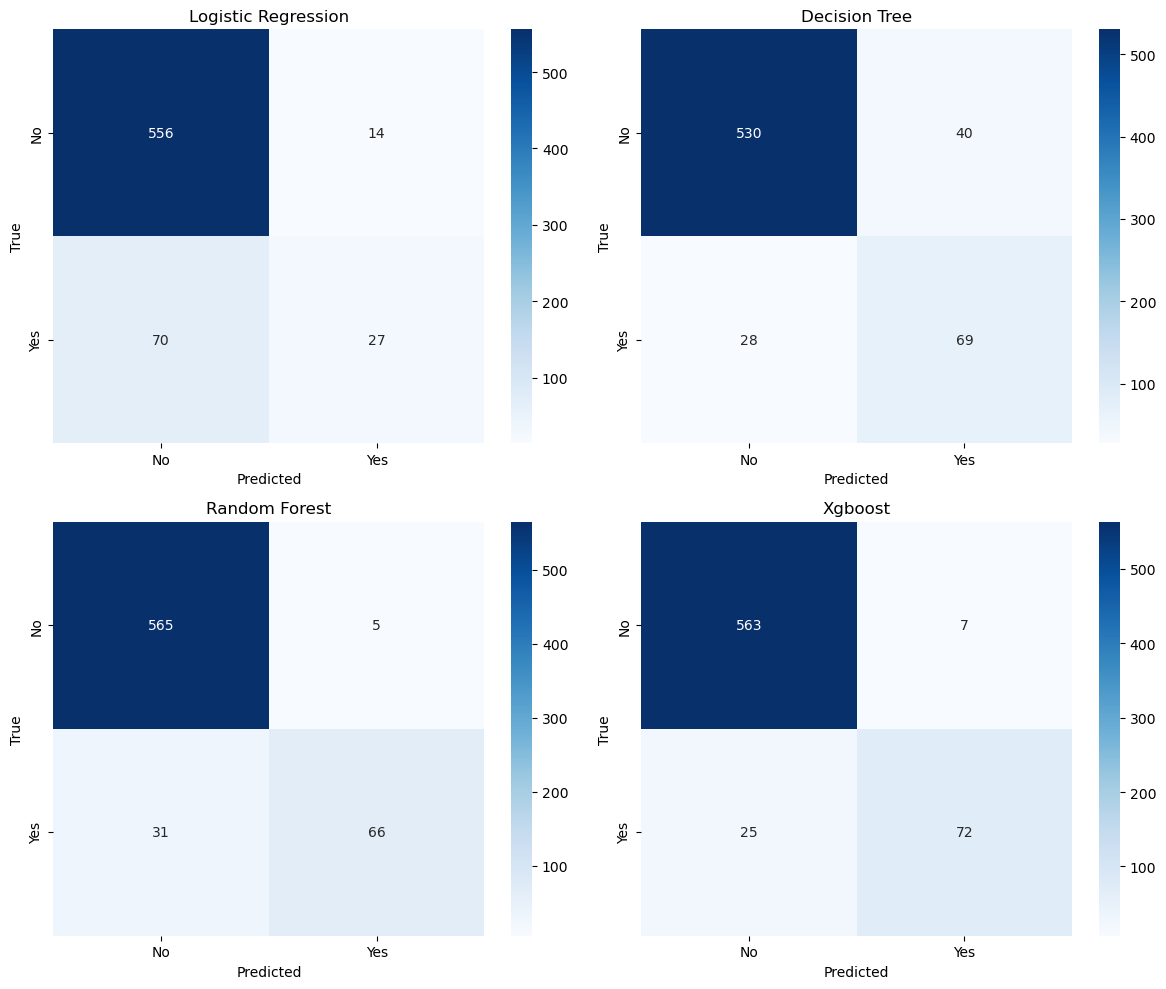

In [26]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for i, r in enumerate(results):
    cm = confusion_matrix(r["y_true"], r["y_pred"])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
    axes[i].set_title(f"{r['model']}")
    axes[i].set_ylabel("True")
    axes[i].set_xlabel("Predicted")

plt.tight_layout()
plt.savefig(STATIC_VIZ / "confusion_matrices.png", dpi=150, bbox_inches='tight')
plt.show()

In [28]:
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("ROC Curves", "Precision-Recall Curves"),
    horizontal_spacing=0.15
)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
for i, r in enumerate(results):
    # ROC
    fpr, tpr, _ = roc_curve(r["y_true"], r["y_prob"])
    fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines',
                             name=f"{r['model']} (AUC={r['roc_auc']:.3f})",
                             line=dict(color=colors[i])), row=1, col=1)
    
    # PR
    precision, recall, _ = precision_recall_curve(r["y_true"], r["y_prob"])
    fig.add_trace(go.Scatter(x=recall, y=precision, mode='lines',
                             name=r['model'], line=dict(color=colors[i]), showlegend=False),
                  row=1, col=2)

# Diagonal line for ROC
fig.add_trace(go.Scatter(x=[0,1], y=[0,1], mode='lines',
                         line=dict(color='gray', dash='dash'), showlegend=False), row=1, col=1)

fig.update_layout(height=550, width=1100, template="plotly_white",
                  title_text="Model Comparison: ROC & PR Curves", title_x=0.5)
fig.update_xaxes(title="False Positive Rate", row=1, col=1)
fig.update_yaxes(title="True Positive Rate", row=1, col=1)
fig.update_xaxes(title="Recall", row=1, col=2)
fig.update_yaxes(title="Precision", row=1, col=2)

curve_path = INTER_VIZ / "model_comparison_curves.html"
fig.write_html(curve_path)
print(f"Interactive curves saved → {curve_path}")
fig.show()

Interactive curves saved → ..\visualizations\interactive\model_comparison_curves.html
